In [17]:
import sys
sys.path.append('../../../')
sys.path.append('/home/sheida.rahnamai/GIT/HDN/')
import torch
import pickle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from tifffile import imread
import glob
import matplotlib.patches as patches
import hdbscan as hd
from sklearn.preprocessing import StandardScaler
from hdbscan import prediction
from sklearn.cluster import HDBSCAN
from collections import Counter
from openTSNE import TSNE as otsne
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D

In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

patch_size = 64
sample_size = 100
centre_size = 4
n_channel = 32
hierarchy_level = 3

model_dir = "/Users/sheida.rahnamai/Desktop/gallant-blaze-492-cl1e-3_kl1/model/"
# model_dir = "smb://storage.fht.org/jug/Sheida/HVAE/Hyperparameter_search/legendary-violet-547-2nd-cl1e-3_kl1/model/"

In [5]:
def load_model(dir):
    model = torch.load(dir+"Contrastive_MAE_best_vae.net")
    return model

In [6]:
def load_pickle(file_name):
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    return data

In [7]:
def save_pickle(file_name, data):
    with open(file_name, 'wb') as f:
        pickle.dump(data, f)
    

In [18]:
model = load_model(model_dir)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [7]:
def get_mean(mu, layer):
    return mu[layer][0].cpu().numpy().reshape(n_channel, -1).mean(-1)

In [8]:
def get_mus(model, z):
    n_features = n_channel * hierarchy_level
    data = np.zeros((n_features,))
    model.mode_pred = True
    model.eval()
    with torch.no_grad():
        model.to(device)
        z = z.to(device=device, dtype=torch.float)
        z = z.reshape(1, 1, patch_size, patch_size)
        with torch.no_grad():
            sample = model(z, z, z, model_layers=[0, 1, 2])
            mu = sample["mu"]
            for i in range(hierarchy_level):
                data[i * n_channel : (i + 1) * n_channel] = get_mean(mu, i)
            data = data.T.reshape(-1, n_features)
    return data

In [9]:
golgis = load_pickle("/home/sheida.rahnamai/GIT/HDN/examples/Pixel_Noise/Convallaria/golgi_samples.pkl")
mitochondrias = load_pickle("/home/sheida.rahnamai/GIT/HDN/examples/Pixel_Noise/Convallaria/mitochondria_samples.pkl")
granules = load_pickle("/home/sheida.rahnamai/GIT/HDN/examples/Pixel_Noise/Convallaria/granule_samples.pkl")
golgi_mu, mitochondria_mu, granule_mu = np.array([]), np.array([]), np.array([])

In [10]:
for idx in range(sample_size):
    mu = get_mus(model, golgis[idx])
    golgi_mu = np.append(golgi_mu, mu).reshape(-1, 96)
    mu = get_mus(model, mitochondrias[idx])
    mitochondria_mu = np.append(mitochondria_mu, mu).reshape(-1, 96)
    mu = get_mus(model, granules[idx])
    granule_mu = np.append(granule_mu, mu).reshape(-1, 96)


In [11]:
golgi_mu.shape, mitochondria_mu.shape, granule_mu.shape

((100, 96), (100, 96), (100, 96))

In [23]:
hdbscan_clustering = HDBSCAN(min_cluster_size=3).fit(np.concatenate((golgi_mu, mitochondria_mu, granule_mu)))

In [33]:
counter = Counter(hdbscan_clustering.labels_)
counter

Counter({0: 100, 2: 100, 1: 100})

In [115]:
tsne = []
tsne = TSNE(
    n_components=2,
    random_state=42,
    method="exact",
    learning_rate="auto",
    init="pca",
    metric="cosine",
    n_iter=10000,
    n_iter_without_progress=500,
).fit_transform(np.concatenate((golgi_mu, mitochondria_mu, granule_mu), axis=0))

In [116]:
def scat(ax, x, y, color, size, lbl, alpha=1, edgecolors="none"):
    ax.scatter(
    x,
    y,
    c=color,
    s=size,
    label=lbl,
    alpha=alpha,
    edgecolors=edgecolors,
    )

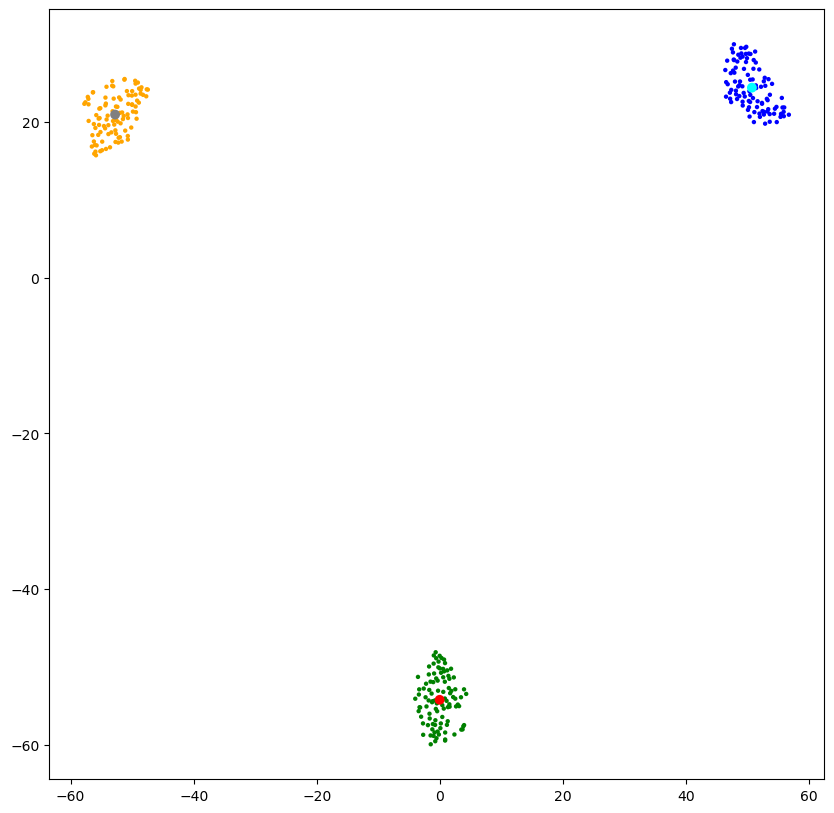

In [117]:
golgi = tsne[:sample_size]
mitochondria = tsne[sample_size:2*sample_size]
granule = tsne[2*sample_size:]
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

scat(ax, golgi.T[0], golgi.T[1], "orange", 10, "Golgi")
scat(ax, golgi.T[0].mean(axis=0), golgi.T[1].mean(axis=0), "gray", 50, "Golgi mean")
scat(ax, mitochondria.T[0], mitochondria.T[1], "blue", 10, "Mitochondria")
scat(ax, mitochondria.T[0].mean(axis=0), mitochondria.T[1].mean(axis=0), "cyan", 50, "Mitochondria mean")
scat(ax, granule.T[0], granule.T[1], "green", 10, "Granule")
scat(ax, granule.T[0].mean(axis=0), granule.T[1].mean(axis=0), "red", 50, "Granule mean")

plt.show()

In [45]:
def get_normalized_tensor(img,model,device):
    test_images = torch.from_numpy(img.copy()).to(device)
    data_mean = model.data_mean
    data_std = model.data_std
    test_images = (test_images-data_mean)/data_std
    return test_images

In [46]:
def load_data(dir):
    return imread(dir)

In [47]:
data_dir = "/localscratch/test_imgs/*"

In [48]:
imgs = load_data(sorted(glob.glob(data_dir)))

In [49]:
def mirror_image(image):
    """
    Mirror the borders of the image to handle edge cases.
    """
    # pad_size = (patch_size - centre_size) // 2
    pad_size = (patch_size + centre_size)// 2

    mirrored_image = np.pad(image, ((pad_size, pad_size)), mode='reflect')
    return mirrored_image

In [50]:
def pad_to_divisible_by(image, centre_size):
    """
    Pads the image so that its dimensions are divisible by 4.
    """
    h, w = image.shape[:2]
    
    # Calculate the padding needed for each dimension
    pad_h = (centre_size - h % centre_size) % centre_size
    pad_w = (centre_size - w % centre_size) % centre_size
    
    # Padding in (before, after) format
    padding = ((0, pad_h), (0, pad_w)) + ((0, 0),) * (image.ndim - 2)
    
    # Pad the image
    padded_image = np.pad(image, padding, mode='reflect')
    
    return padded_image

In [51]:
def extract_patch(image, x, y):
    """
    Extract a patch from the image centered at (x, y).
    """
    return image[x : x + patch_size, y : y + patch_size]

In [52]:
def predict_feature_maps(model, image, x, y):
    """
    Predict the feature maps for an image using the model.
    """
    patch = extract_patch(image, x, y)
    mus = get_mus(model, patch)
    return mus

In [53]:
img = imgs[10][100:228, 100:228]
img = get_normalized_tensor(pad_to_divisible_by(mirror_image(img), centre_size),model,device)

height, width= img.shape
print(height, width)
feature_maps = [[[] for _ in range(width)] for _ in range(height)]

196 196


In [54]:
pad_size = (patch_size - centre_size) // 2

In [55]:
def append_vector(i, j, vector):
    for k in range(centre_size):
        for l in range(centre_size):
            feature_maps[i+k+pad_size+1][j+l+pad_size+1].append(vector)

In [56]:
height, width= img.shape
for x in range(0, height - patch_size, 1):
    for y in range(0, width - patch_size, 1):
        append_vector(x, y, predict_feature_maps(model, img, x, y))

In [64]:
len(feature_maps), len(feature_maps[0])

(196, 196)

In [65]:
max_m = max(len(feature_maps[i][j]) for i in range(height) for j in range(width))
print(max_m)
for i in range(height):
    for j in range(width):
        if feature_maps[i][j] == 16:
            print(i, j)

16


In [66]:
result_array = np.zeros((height, width, max_m, 96))
for i in range(height):
    for j in range(width):
        for k in range(len(feature_maps[i][j])):
            result_array[i, j, k, :] = feature_maps[i][j][k]
minx, miny = height, width
maxx, maxy = 0, 0
for i in range(height):
    for j in range(width):
        if len(feature_maps[i][j]) == 16:
            minx = min(minx, i)
            miny = min(miny, j)
            maxx = max(maxx, i)
            maxy = max(maxy, j)


In [67]:
print(minx, miny, maxx, maxy)

34 34 162 162


(128, 128, 96)


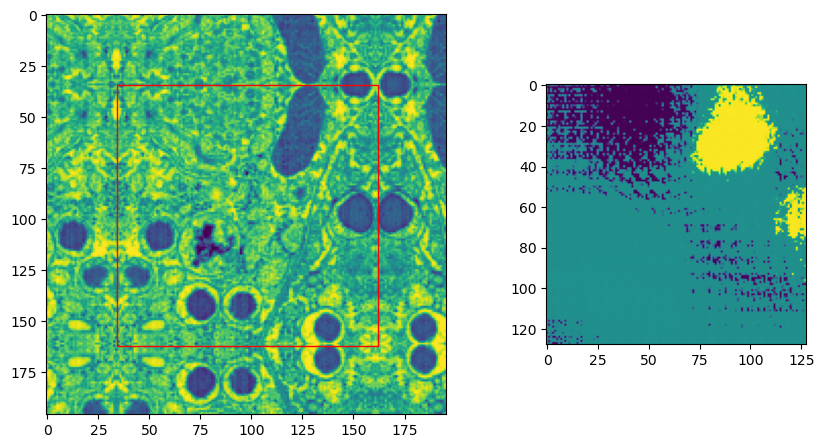

In [68]:
print(result_array[minx:maxx, miny:maxy, 0, :].shape)
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.6, 0.8])
ax1.imshow(img.cpu().numpy())
ax2 = fig.add_axes([0.7, 0.1, 0.26, 0.8])
ax2.imshow(result_array[minx:maxx, miny:maxy, 0, :].mean(axis=2))
square = patches.Rectangle((minx, miny), maxx-minx, maxy-miny, linewidth=1, edgecolor='r', facecolor='none')
ax1.add_patch(square)
plt.show()

In [69]:
print(result_array[minx:maxx, miny:maxy, 0].shape)

(128, 128, 96)


In [70]:
test_data = result_array[minx:maxx, miny:maxy, 0].reshape(-1, 96)
save_pickle("test_data.pkl", test_data)

In [72]:
train_data = np.concatenate((golgi_mu, mitochondria_mu, granule_mu), axis=0)
save_pickle("train_data.pkl", train_data)

In [135]:
tsne = otsne(
    n_components=2,
    random_state=42,
    learning_rate="auto",
    metric="cosine",
    n_iter=10000,
).fit(np.concatenate((golgi_mu, mitochondria_mu, granule_mu), axis=0))

In [136]:
new_sample_embedding = tsne.transform(result_array[minx:maxx, miny:maxy, 0].reshape(-1, 96))

In [137]:
new_sample_embedding.shape

(16384, 2)

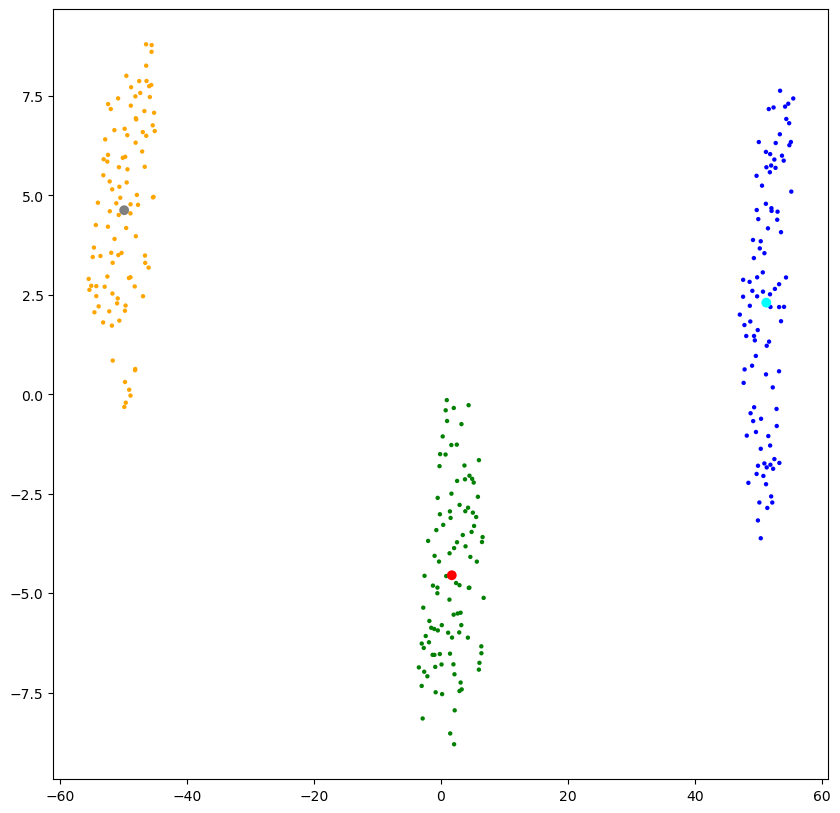

In [139]:
golgi = tsne[:sample_size]
mitochondria = tsne[sample_size:2*sample_size]
granule = tsne[2*sample_size:]
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)


# scat(ax, new_sample_embedding.T[0], new_sample_embedding.T[1], "black", 5, "New Sample")
scat(ax, golgi.T[0], golgi.T[1], "orange", 10, "Golgi")
scat(ax, golgi.T[0].mean(axis=0), golgi.T[1].mean(axis=0), "gray", 50, "Golgi mean")
scat(ax, mitochondria.T[0], mitochondria.T[1], "blue", 10, "Mitochondria")
scat(ax, mitochondria.T[0].mean(axis=0), mitochondria.T[1].mean(axis=0), "cyan", 50, "Mitochondria mean")
scat(ax, granule.T[0], granule.T[1], "green", 10, "Granule")
scat(ax, granule.T[0].mean(axis=0), granule.T[1].mean(axis=0), "red", 50, "Granule mean")
plt.show()

In [42]:
new_sample_embedding_2 = tsne.transform(result_array[minx:maxx, miny:maxy, 1].reshape(-1, 96))

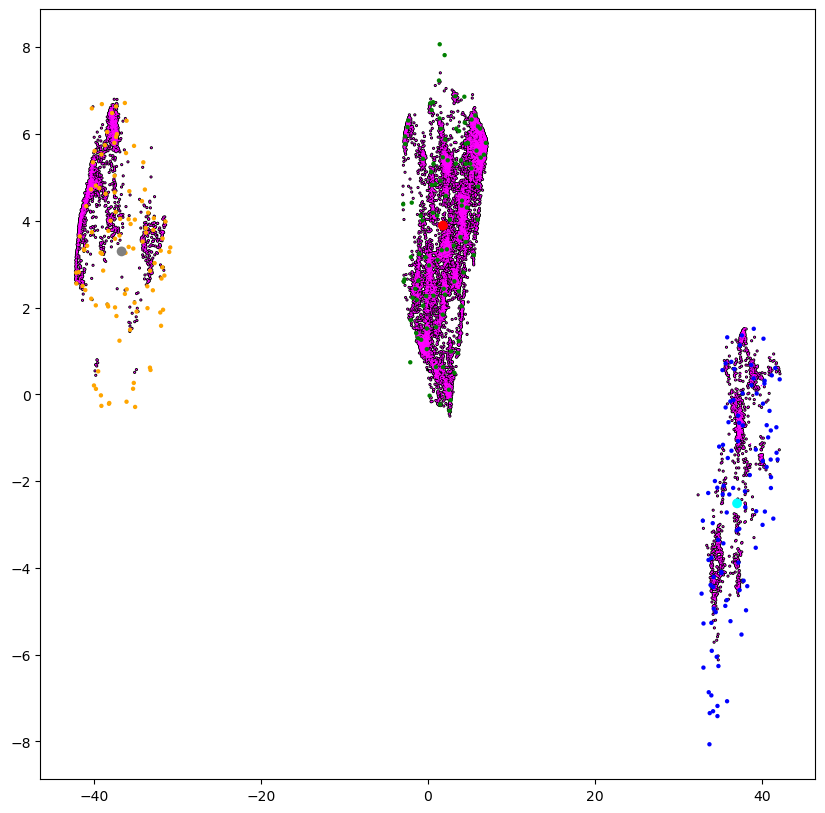

In [44]:
golgi = tsne[:sample_size]
mitochondria = tsne[sample_size:2*sample_size]
granule = tsne[2*sample_size:]
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)


scat(ax, new_sample_embedding.T[0], new_sample_embedding.T[1], "black", 5, "New Sample")
scat(ax, new_sample_embedding_2.T[0], new_sample_embedding_2.T[1], "magenta", 1, "New Sample 2")
scat(ax, golgi.T[0], golgi.T[1], "orange", 10, "Golgi")
scat(ax, golgi.T[0].mean(axis=0), golgi.T[1].mean(axis=0), "gray", 50, "Golgi mean")
scat(ax, mitochondria.T[0], mitochondria.T[1], "blue", 10, "Mitochondria")
scat(ax, mitochondria.T[0].mean(axis=0), mitochondria.T[1].mean(axis=0), "cyan", 50, "Mitochondria mean")
scat(ax, granule.T[0], granule.T[1], "green", 10, "Granule")
scat(ax, granule.T[0].mean(axis=0), granule.T[1].mean(axis=0), "red", 50, "Granule mean")
plt.show()

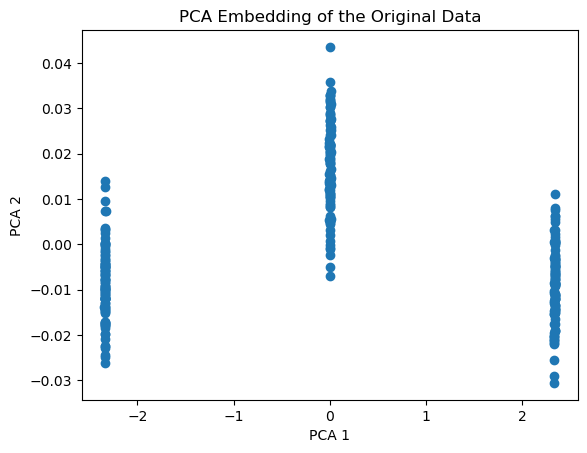

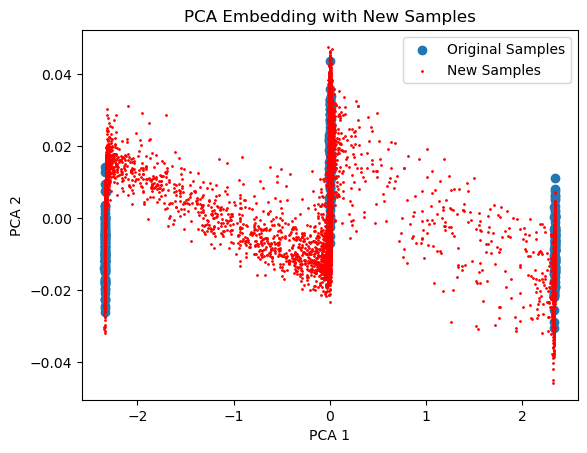

In [49]:
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca.fit(np.concatenate((golgi_mu, mitochondria_mu, granule_mu), axis=0))
data_embedding = pca.transform(np.concatenate((golgi_mu, mitochondria_mu, granule_mu), axis=0))
plt.scatter(data_embedding[:, 0], data_embedding[:, 1])
plt.title('PCA Embedding of the Original Data')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()
new_samples_embedding = pca.transform(result_array[minx:maxx, miny:maxy, 0].reshape(-1, 96))
plt.scatter(data_embedding[:, 0], data_embedding[:, 1], label='Original Samples')
plt.scatter(new_samples_embedding[:, 0], new_samples_embedding[:, 1], color='red',s=1, label='New Samples')
plt.title('PCA Embedding with New Samples')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

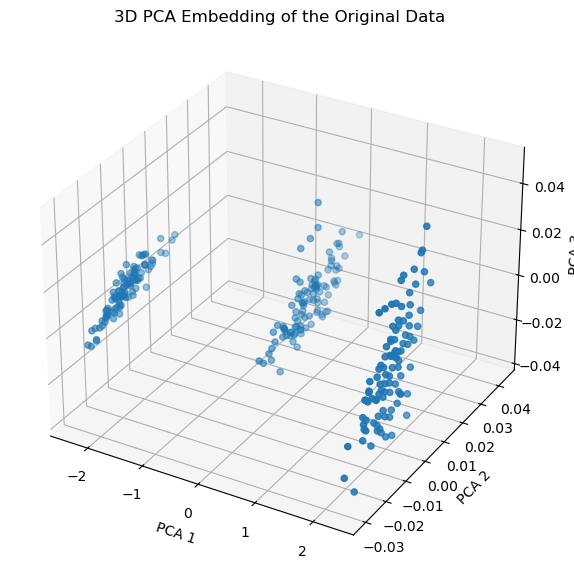

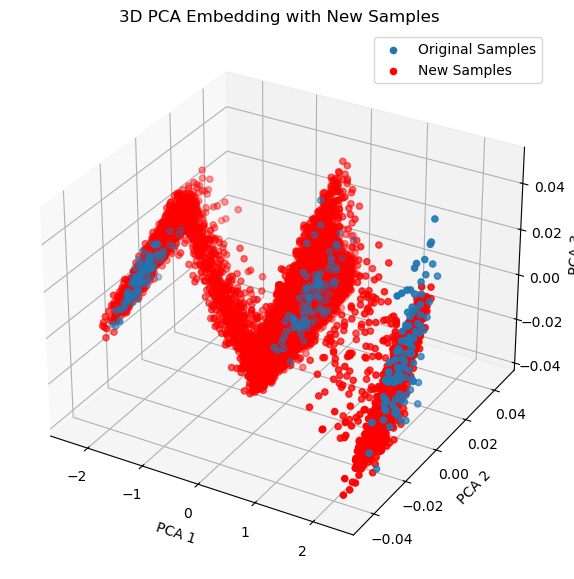

In [57]:
pca = PCA(n_components=3)  # Reduce to 3 components for visualization
pca.fit(np.concatenate((golgi_mu, mitochondria_mu, granule_mu), axis=0))
data_embedding = pca.transform(np.concatenate((golgi_mu, mitochondria_mu, granule_mu), axis=0))


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_embedding[:, 0], data_embedding[:, 1], data_embedding[:, 2])
ax.set_title('3D PCA Embedding of the Original Data')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.show()


new_samples_embedding = pca.transform(result_array[minx:maxx, miny:maxy, 0].reshape(-1, 96))

# Plot the embedding including the new samples in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_embedding[:, 0], data_embedding[:, 1], data_embedding[:, 2], label='Original Samples')
ax.scatter(new_samples_embedding[:, 0], new_samples_embedding[:, 1], new_samples_embedding[:, 2], color='red', label='New Samples')
ax.set_title('3D PCA Embedding with New Samples')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.legend()
plt.show()

In [75]:
golgi_mean = np.mean(data_embedding[:100], axis=0)
mito_mean = np.mean(data_embedding[100:200], axis=0)
gra_mean = np.mean(data_embedding[200:], axis=0)
print(golgi_mean, mito_mean, gra_mean)

[-2.33845406 -0.00862117  0.00288741] [ 2.33713141 -0.00865154  0.00287083] [ 0.00132265  0.0172727  -0.00575825]


In [76]:
new_samples_embedding.shape

(16384, 3)

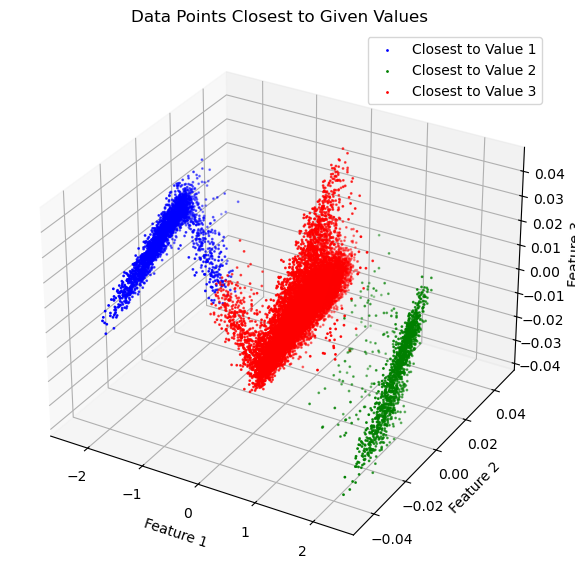

((2620, 3), (1398, 3), (12366, 3))

In [96]:
means = np.array([golgi_mean, mito_mean, gra_mean])
distances = cdist(new_samples_embedding, means, metric='euclidean')

closest_value_indices = np.argmin(distances, axis=1)

data_closest_to_value1 = new_samples_embedding[closest_value_indices == 0]
data_closest_to_value2 = new_samples_embedding[closest_value_indices == 1]
data_closest_to_value3 = new_samples_embedding[closest_value_indices == 2]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points closest to each value with different colors
ax.scatter(data_closest_to_value1[:, 0], data_closest_to_value1[:, 1], data_closest_to_value1[:, 2], color='blue', s=1,label='Closest to Value 1')
ax.scatter(data_closest_to_value2[:, 0], data_closest_to_value2[:, 1], data_closest_to_value2[:, 2], color='green', s=1,label='Closest to Value 2')
ax.scatter(data_closest_to_value3[:, 0], data_closest_to_value3[:, 1], data_closest_to_value3[:, 2], color='red', s=1,label='Closest to Value 3')


ax.set_title('Data Points Closest to Given Values')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.legend()

plt.show()
data_closest_to_value1.shape, data_closest_to_value2.shape, data_closest_to_value3.shape

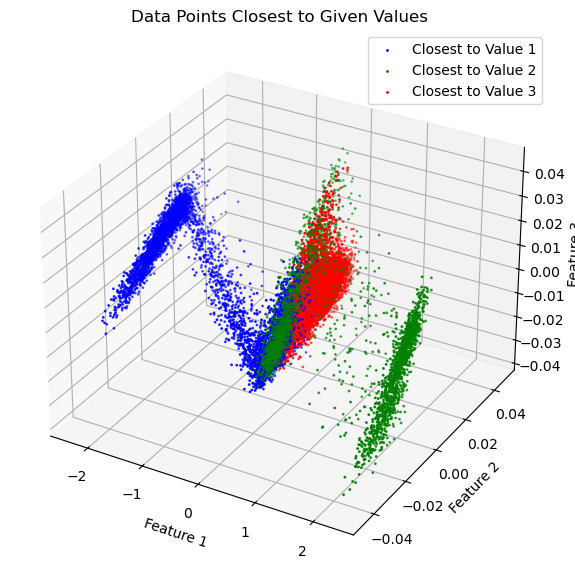

((4837, 3), (2941, 3), (8606, 3))

In [97]:
means = np.array([golgi_mean, mito_mean, gra_mean])
distances = cdist(new_samples_embedding, means, metric='cosine')

closest_value_indices = np.argmin(distances, axis=1)

data_closest_to_value1 = new_samples_embedding[closest_value_indices == 0]
data_closest_to_value2 = new_samples_embedding[closest_value_indices == 1]
data_closest_to_value3 = new_samples_embedding[closest_value_indices == 2]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points closest to each value with different colors
ax.scatter(data_closest_to_value1[:, 0], data_closest_to_value1[:, 1], data_closest_to_value1[:, 2], color='blue', s=1,label='Closest to Value 1')
ax.scatter(data_closest_to_value2[:, 0], data_closest_to_value2[:, 1], data_closest_to_value2[:, 2], color='green', s=1,label='Closest to Value 2')
ax.scatter(data_closest_to_value3[:, 0], data_closest_to_value3[:, 1], data_closest_to_value3[:, 2], color='red', s=1,label='Closest to Value 3')


ax.set_title('Data Points Closest to Given Values')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.legend()

plt.show()
data_closest_to_value1.shape, data_closest_to_value2.shape, data_closest_to_value3.shape

In [103]:
closest_value_indices

array([0, 0, 0, ..., 2, 2, 2])

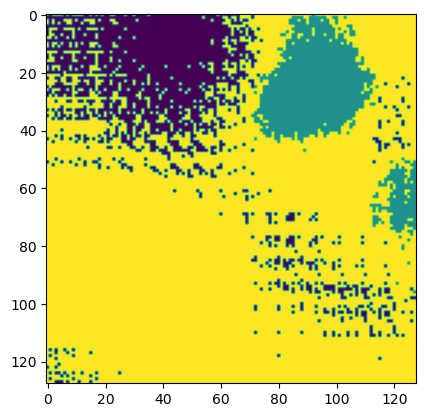

In [65]:
plt.imshow(closest_value_indices.reshape(128, 128))

In [12]:
train_data = load_pickle("train_data.pkl")
test_data = load_pickle("test_data.pkl")

In [73]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [77]:
type(test_data_scaled)

numpy.ndarray

In [79]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels = clusterer.fit_predict(train_data_scaled)
clusterer.generate_prediction_data()
print("Original cluster labels:", cluster_labels)
new_labels, new_probabilities = prediction.approximate_predict(clusterer, test_data_scaled)
print("New cluster labels:", new_labels)
print("New cluster probabilities:", new_probabilities)

Original cluster labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]
New cluster labels: [1 0 1 ... 1 1 1]
New cluster probabilities: [0.69462004 0.40581528 0.65934528 ... 0.93828035 0.84363727 0.86264653]


In [81]:
counter = Counter(cluster_labels)
counter

Counter({0: 100, 2: 100, 1: 100})

In [82]:
counter = Counter(new_labels)
counter

Counter({1: 12344, 0: 2621, 2: 1419})

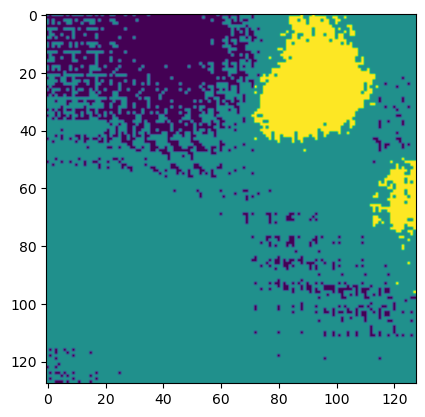

In [85]:
plt.imshow(new_labels.reshape(128, 128))